In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

In [2]:
from filters import helpers, kalman, stats
from models import const_acc, const_vel, noise
from plots import plot_common, plot_kf
from simulators import linear

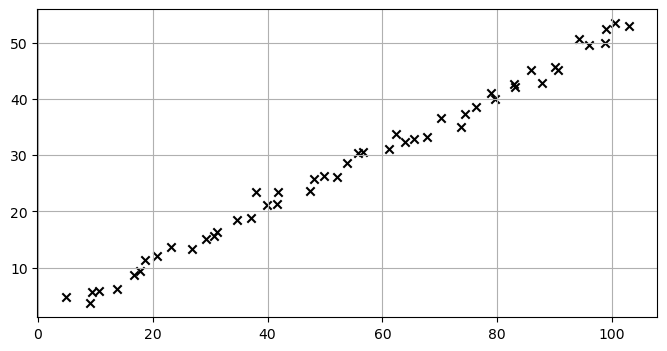

In [3]:
pos, vel = (4, 3), (2, 1)
sensor = linear.PosSensor(pos, vel, R=1)
ps = np.array([sensor.read() for _ in range(50)])

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_zs(ax, xs=ps[:, 0], ys=ps[:, 1])

## A demo KF


In [4]:
R_std = 0.025
Q_std = 1
dt = 1
dim_x = 4
dim_z = 2


def tracker1():
    tracker = kalman.KalmanFilter(dim_x=dim_x, dim_z=dim_z)
    dt = 1.0  # time step
    tracker.F = np.array(
        [[1, dt, 0, 0], [0, 1, 0, 0], [0, 0, 1, dt], [0, 0, 0, 1]],
    )
    tracker.u = 0.0
    tracker.H = np.array([[1 / 0.3048, 0, 0, 0], [0, 0, 1 / 0.3048, 0]])
    tracker.R = np.eye(dim_z) * R_std**2
    q = noise.white_noise_discrete(dim=2, dt=1, var=Q_std**2)
    tracker.Q = linalg.block_diag(q, q)
    tracker.P = np.eye(dim_x) * 50.0
    tracker.x = np.array([[0, 0, 0, 0]]).T
    return tracker

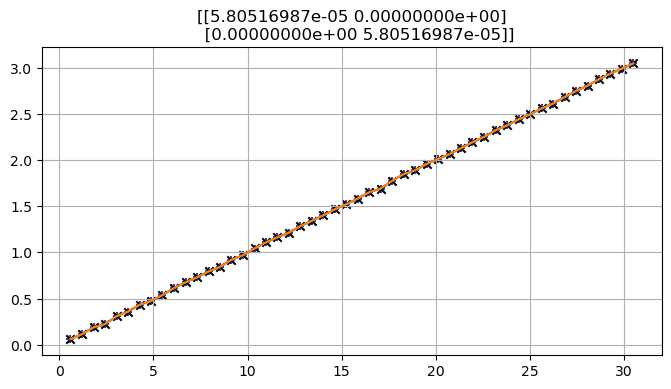

In [5]:
N = 50
sensor = linear.PosSensor((0, 0), (2, 0.2), R=R_std)

zs = np.array([sensor.read() for _ in range(N)])

# run filter
robot_tracker = tracker1()
mu, cov, _, _ = robot_tracker.batch_filter(zs)

_, ax = plt.subplots(figsize=(8, 4))

for x, P in zip(mu, cov):
    # covariance of x and y
    cov = np.array([[P[0, 0], P[2, 0]], [P[0, 2], P[2, 2]]])
    mean = (x[0, 0], x[2, 0])
    plot_common.plot_cov_ellipse(ax, mean, cov=cov, facecolor="g", stds=[3], alpha=0.5)

# plot results
zs *= 0.3048  # convert to meters
plot_common.plot_zs(ax, zs[:, 0], zs[:, 1])
plot_kf.plot_kf(ax, mu[:, 0], mu[:, 2])

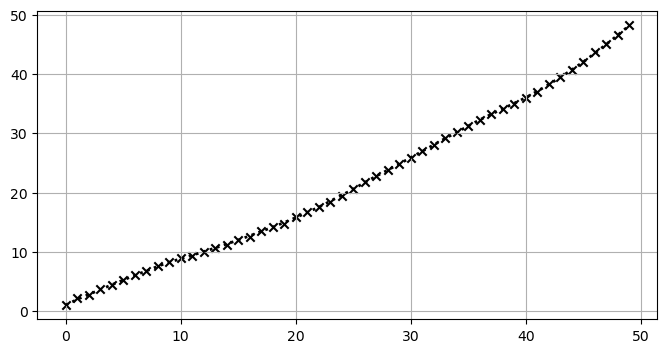

In [6]:
np.random.seed(124)
cvobj = linear.CVObject()

xs, zs = [], []
for _ in range(50):
    x = cvobj.update()
    z = cvobj.sense()
    xs.append(x)
    zs.append(z)

xs = np.asarray(xs)

_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_track(ax, xs[:, 0])
plot_common.plot_zs(ax, range(len(zs)), zs)

## Varying Order


In [7]:
def filter_data(kf, zs):
    s = helpers.KFSaver(kf)
    kf.batch_filter(zs, saver=s)
    s.to_array()
    return s

### 1st Order


In [8]:
R, Q = 1, 0.03
cvobj = linear.CVObject(Q=Q, R=R)

xs, zs = cvobj.simulate(count=50)

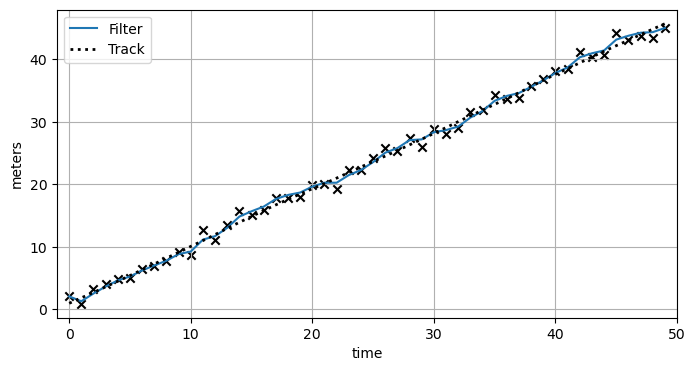

In [9]:
P = np.array([[100, 0], [0, 1]])
kf = const_vel.KFCV2d(P=P, R=R, Q=Q, dt=1)
data = filter_data(kf, zs)

_, ax = plt.subplots(figsize=(8, 4))

plot_kf.plot_kf_track(ax, xs, data.x, data.z)

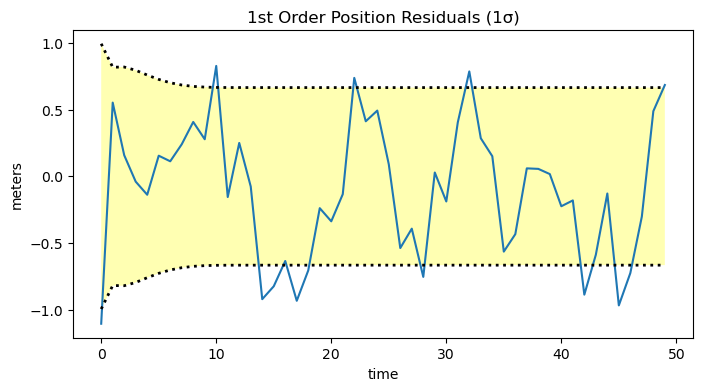

In [10]:
_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_resids(
    ax,
    xs[:, 0],
    data,
    col=0,
    title="1st Order Position Residuals (1σ)",
    ylabel="meters",
)

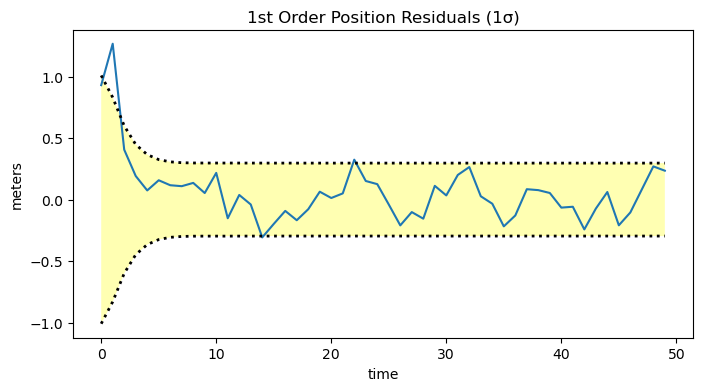

In [11]:
_, ax = plt.subplots(figsize=(8, 4))

plot_common.plot_resids(
    ax,
    xs[:, 1],
    data,
    col=1,
    title="1st Order Position Residuals (1σ)",
    ylabel="meters",
)

### 0th Order


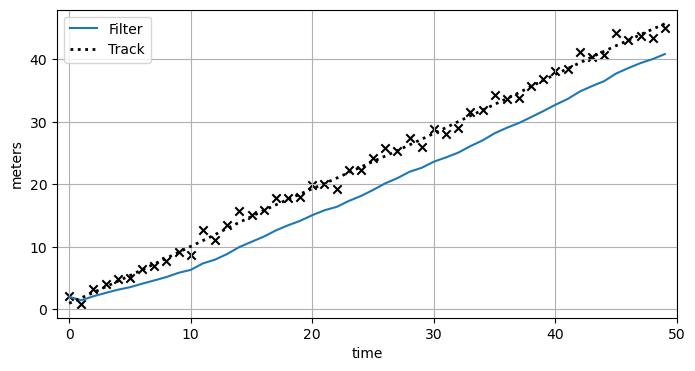

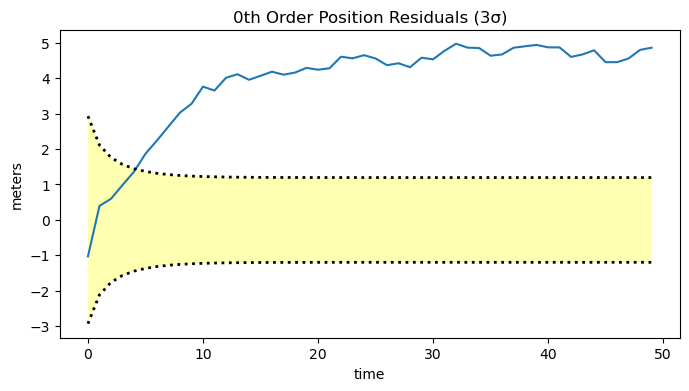

In [12]:
kf0 = const_vel.KFCV1d(P=20, R=R, Q=Q)
data0 = filter_data(kf0, zs)

_, ax = plt.subplots(figsize=(8, 4))
plot_kf.plot_kf_track(ax, xs, data0.x, data0.z)

_, ax = plt.subplots(figsize=(8, 4))
plot_common.plot_resids(
    ax,
    xs[:, 0],
    data0,
    col=0,
    title="0th Order Position Residuals (3σ)",
    ylabel="meters",
    stds=3,
)

### 2nd Order


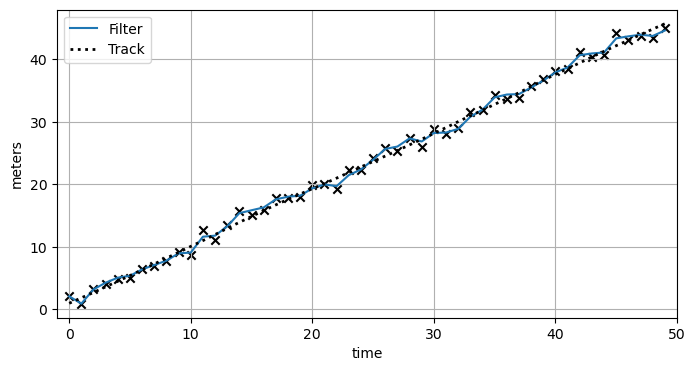

In [13]:
kf2 = const_acc.KFCA3d(P=100, R=R**2, Q=Q, dt=1)
data2 = filter_data(kf2, zs)

_, ax = plt.subplots(figsize=(8, 4))

plot_kf.plot_kf_track(ax, xs, data2.x, data2.z)

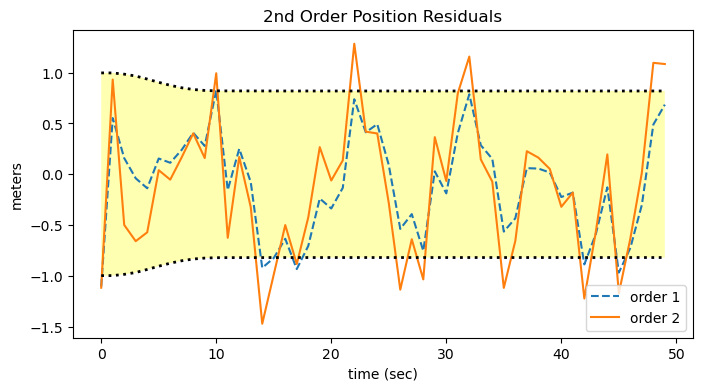

In [14]:
res2 = xs[:, 0] - data2.x[:, 0]
res1 = xs[:, 0] - data.x[:, 0]

_, ax = plt.subplots(figsize=(8, 4))

ax.plot(res1, ls="--", label="order 1")
ax.plot(res2, label="order 2")
plot_common.plot_resids_lims(ax, data2.P[:, 0, 0])

ax.set(title="2nd Order Position Residuals", xlabel="time (sec)", ylabel="meters")
ax.legend()

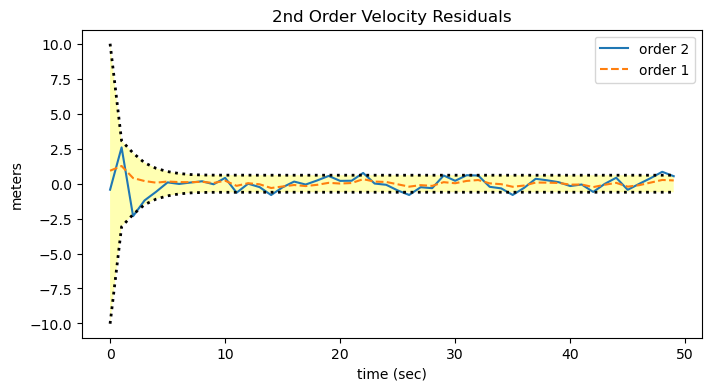

In [15]:
res2 = xs[:, 1] - data2.x[:, 1]
res1 = xs[:, 1] - data.x[:, 1]

_, ax = plt.subplots(figsize=(8, 4))
ax.plot(res2, label="order 2")
ax.plot(res1, ls="--", label="order 1")
plot_common.plot_resids_lims(ax, data2.P[:, 1, 1])

ax.set(title="2nd Order Velocity Residuals", xlabel="time (sec)", ylabel="meters")
ax.legend()

## Varying Q


### Q=0


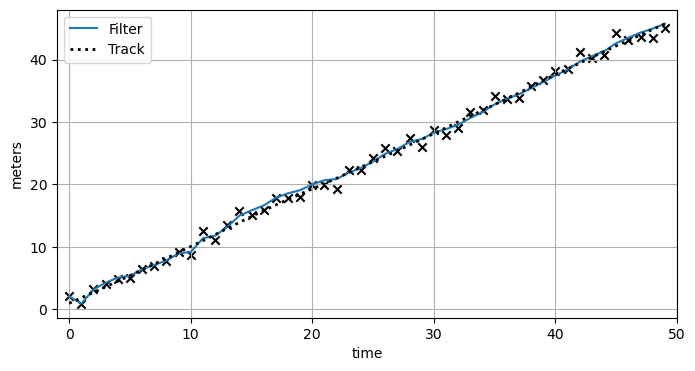

In [17]:
kf2 = const_acc.KFCA3d(P=100, R=R**2, Q=0, dt=1)
data2 = filter_data(kf2, zs)

_, ax = plt.subplots(figsize=(8, 4))
plot_kf.plot_kf_track(ax, xs, data2.x, data2.z)

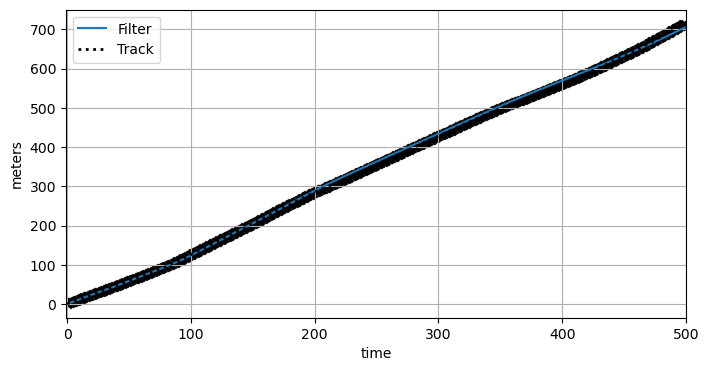

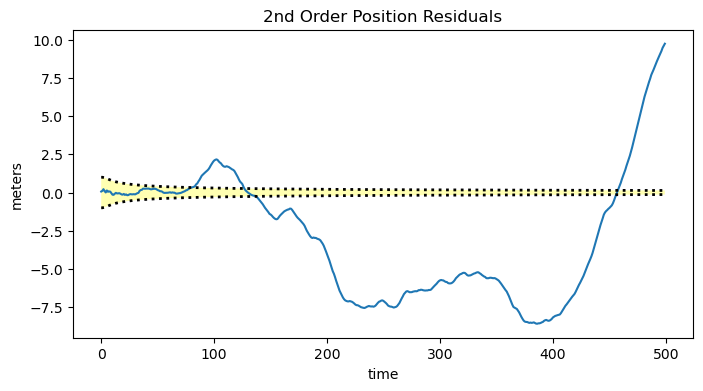

In [19]:
np.random.seed(1)
R, Q = 1, 0.03
cvobj = linear.CVObject(Q=Q)

xs500, zs500 = cvobj.simulate(count=500)
kf2 = const_acc.KFCA3d(P=100, R=R**2, Q=0, dt=1)
data500 = filter_data(kf2, zs500)

_, ax = plt.subplots(figsize=(8, 4))
plot_kf.plot_kf_track(ax, xs500, data500.x, data500.z)

_, ax = plt.subplots(figsize=(8, 4))
plot_common.plot_resids(
    ax,
    xs500[:, 0],
    data500,
    col=0,
    title="2nd Order Position Residuals",
    ylabel="meters",
)

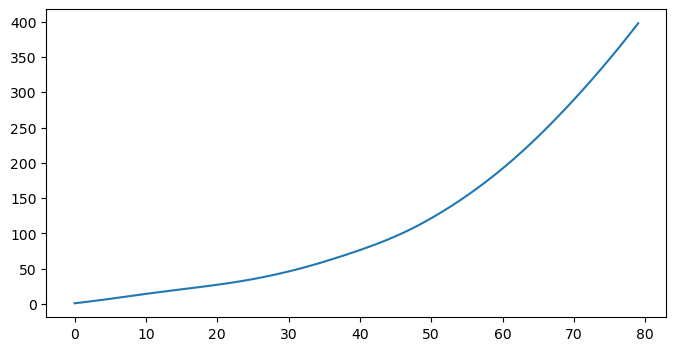

In [20]:
R, Q = 6.0, 0.02

np.random.seed(124)
caobj = linear.CAObject(Q=Q, R=R)
xs, zs = caobj.simulate(count=80)

_, ax = plt.subplots(figsize=(8, 4))
ax.plot(xs[:, 0])

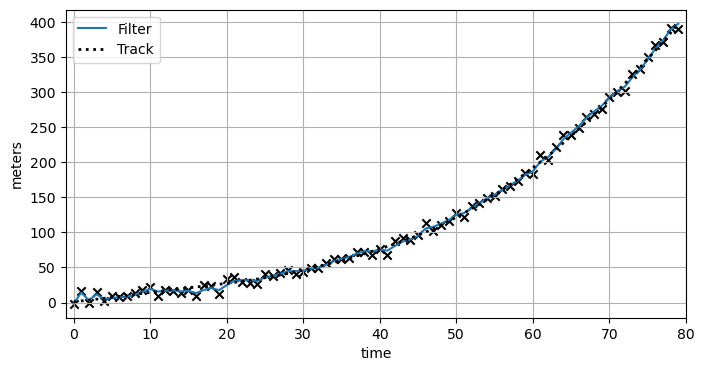

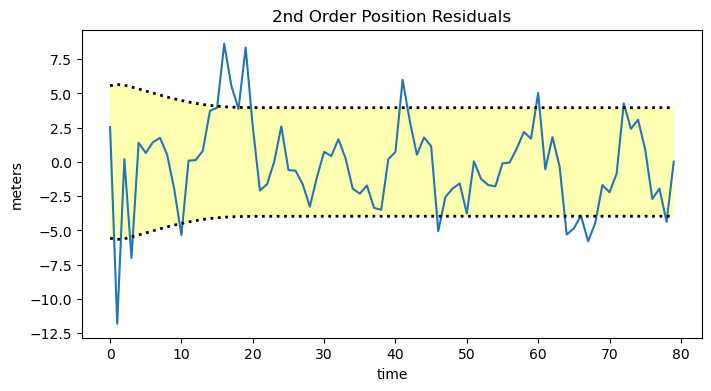

In [22]:
np.random.seed(124)

kf2 = const_acc.KFCA3d(P=100, R=R**2, Q=Q, dt=1)
data2 = filter_data(kf2, zs)

_, ax = plt.subplots(figsize=(8, 4))
plot_kf.plot_kf_track(ax, xs, data2.x, data2.z)

_, ax = plt.subplots(figsize=(8, 4))
plot_common.plot_resids(
    ax, xs[:, 0], data2, col=0, title="2nd Order Position Residuals", ylabel="meters"
)

### Increase Q


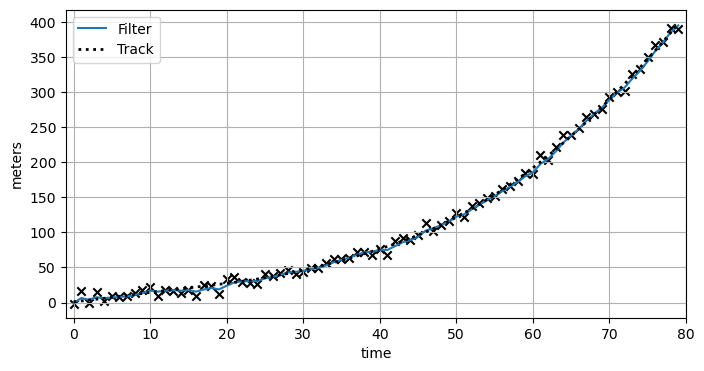

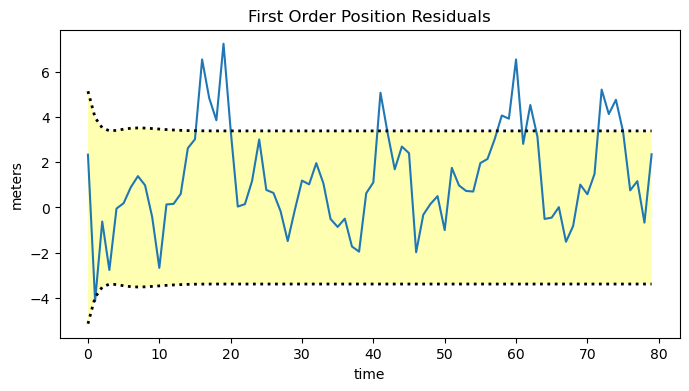

In [23]:
kf3 = const_vel.KFCV2d(P=np.array([[100, 0], [0, 1]]), R=R**2, Q=Q * 10, dt=1)
data3 = filter_data(kf3, zs)

_, ax = plt.subplots(figsize=(8, 4))
plot_kf.plot_kf_track(ax, xs, data3.x, data3.z)

_, ax = plt.subplots(figsize=(8, 4))
plot_common.plot_resids(
    ax, xs[:, 0], data3, 0, title="First Order Position Residuals", ylabel="meters"
)

## Performance


### State Variable


In [25]:
np.random.seed(1)

R, Q = 6.0, 0.02
caobj = linear.CAObject(Q=Q, R=R)
xs, zs = caobj.simulate(count=80)

kf2 = const_acc.KFCA3d(P=100, R=R, Q=Q, dt=1)
est_xs, ps, _, _ = kf2.batch_filter(zs)
nees = stats.NEES(xs, est_xs, ps)
eps = np.mean(nees)
print("mean NEES is: ", eps)

if eps < kf2.dim_x:
    print("passed")
else:
    print("failed")

mean NEES is:  11.113445205239827
failed
